# Co-Simulation of Unit under test

A bit more complex example for simultaneous verification of the MyHDL behaviour and the simulation of the synthesized Verilog code.

Take this hypothetical design. It does not do anything useful except trying to be a little more complex instead of well designed. So it is likely to be debugged by someone.

We will in this example look at:

* Running the original model in parallel with the post-synthesis simulation for verification
* Dumping waveforms of signal traces

In [1]:
from myhdl import *

@block
def counter_example(clk, ce, reset, dout, debug):
    counter = Signal(modbv(0)[8:])
    x = Signal(modbv()[2:])
    y = Signal(modbv()[2:])

    d = Signal(intbv(3)[2:])

    @always_seq(clk.posedge, reset)
    def worker():
        if ce:
            debug.next = counter[4]
            counter.next = counter + 1
            d.next = 2
        else:
            d.next = 1
            debug.next = 0
            counter.next = counter

    @always_comb
    def select():
        if counter == 3:
            x.next = d + 1
            y.next = 2
        elif counter == 9:
            x.next = d - 1
            y.next = 1
        elif counter == 22:
            x.next = 2
            y.next = 0
        else:
            if ce:
                x.next = 0
                y.next = 3
            else:
                x.next = 1
                y.next = 1

    @always_comb
    def assign():
        dout.next = x ^ y

    return instances()




Our test bench plus a clock generator and a **L**inear **F**eedback **S**hift **R**egister as external stimulus:

In [2]:

@block
def clkgen(clk, DELAY):
    @always(delay(DELAY))
    def clkgen():
        clk.next = not clk

    return instances()

@block
def lfsr8(clk, enable, reset, rval, dout):
    """LFSR with all states"""
    v = Signal(modbv(rval)[8:])
    fb = Signal(bool())

    @always_seq(clk.posedge, reset)
    def worker():
        if enable == 1:
            v.next = concat(v[6], v[5], v[4], v[3] ^ fb, v[2] ^ fb, v[1] ^ fb, v[0], fb)

    @always_comb
    def assign():
        e = v[7:0] == 0
        fb.next = v[7] ^ e
        dout.next = v


    return instances()


@block
def tb_unit(uut, uut_syn, async_reset):
    """This test bench instances two units in parallel:
    - The MyHDL simulation instance of the uut entity
    - A Co-Simulation of the post-synthesis output created
    through the yosys API.
    These are run in parallel to compare against each other."""
    mclk = Signal(bool())
    debug, debug_syn = [ Signal(bool(0)) for i in range(2) ]
    ce = Signal(bool())
    dout, do_syn = [ Signal(modbv()[8:]) for i in range(2) ]
    reset = ResetSignal(0, 1, isasync = async_reset)

    # Create a clock generator
    inst_clkgen = clkgen(mclk, 1)
    # Create an instance of the MyHDL entity:
    inst_uut = uut(mclk, ce, reset, dout, debug)
    # Create an instance of the Co-Simulation object wrapper:
    inst_syn = uut_syn(uut, mclk, ce, reset, do_syn, debug_syn)

    r0 = Signal(modbv()[8:])

    inst_lfsr0 = lfsr8(mclk, 1, reset, 0, r0)

    @always_comb
    def assign():
        ce.next = r0[0]

    @instance
    def stimulus():
        # errcount = 0
        reset.next = 1
        yield(delay(4))
        reset.next = 0
        while 1:
            yield mclk.posedge
            print(dout, debug, " --- ", do_syn, debug_syn)
            if dout != do_syn or debug != debug_syn:
                yield mclk.posedge
                yield mclk.posedge
                yield mclk.posedge
                raise ValueError("Simulation mismatch")

    return instances()


## Conversion and synthesis

These routines convert the MyHDL design to an internal representation and emit synthesizeable Verilog (post-synthesis).
This is later used to verify the MyHDL behaviour against the synthesized result.

CONVERT YOSYS
CREATE Module: 'counter_example'
Adding module with name: counter_example_1_1_1_8_1
TRUNC: <ipython-input-1-a476ea12b3b4>:15 Implicit carry truncate: counter[8:], src[9:]
NOTICE: <ipython-input-1-a476ea12b3b4>:24 call compare attr
TRUNC: <ipython-input-1-a476ea12b3b4>:25 Implicit carry truncate: x[2:], src[3:]
NOTICE: <ipython-input-1-a476ea12b3b4>:27 call compare attr
NOTICE: <ipython-input-1-a476ea12b3b4>:30 call compare attr
WARN: <ipython-input-1-a476ea12b3b4>:30 no fullcase attr in async process
WARN: <ipython-input-1-a476ea12b3b4>:27 no fullcase attr in async process
wire x:
wire y:
VISIT INSTANCES
DONE instancing submodules
Generating RTL image...
Display...


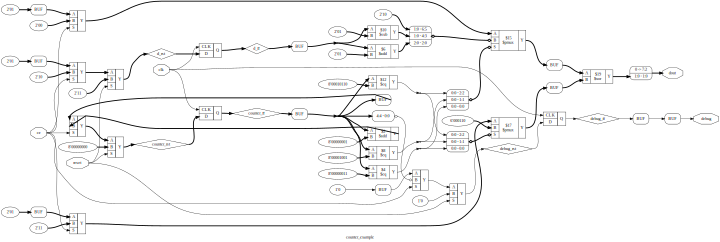

In [3]:
from myhdl.conversion import yshelper
from ys_aux import to_svg


UNIT = counter_example

def convert(ent, async_reset):
    clk = Signal(bool())
    debug = Signal(bool(0))
    ce = Signal(bool())
    dout = Signal(intbv()[8:])
    reset = ResetSignal(0, 1, isasync = async_reset)

    inst = ent(clk, ce, reset, dout, debug)

    d = yshelper.Design("mem")

    print("CONVERT YOSYS")
    inst.convert("yosys_module", d, name=ent.func.__name__, trace=True)

# You might enable that for RTLIL debugging
    #d.write_ilang(ent.func.__name__)

    d.write_verilog(ent.func.__name__, rename_default=True)
    return d


d = convert(UNIT, False)
display(to_svg(d))


## Setting up the cosimulation

This is the detailed set up (as found in the `ys_aux` auxiliary module for later examples) to support a Co-Simulation object. This is created from a simulation command as shown below, that is routed through a VPI co-simulation interface.

The `setupCosimulation()` routine takes a name of an external verilog file (which was generated for us above).
We can list those generated files:

In [4]:
! ls  *mapped.*v

counter_example_mapped.v    tb_counter_example_mapped.v    tb_test_mapped.v
my_assert_success_mapped.v  tb_my_assert_success_mapped.v  test_mapped.v


In [5]:
import os
import subprocess

MYHDL_DIR = os.environ["HOME"] + "/src/myhdl/myhdl-yosys/"

def setupCosimulation(name, use_assert, interface):
    """Auxiliary to return a Co-Simulation object.
    This basically creates a wrapper that calls the iverilog simulator
    to co-simulate a Verilog component against a Python test bench"""
    tb = "tb_" + name
    objfile = "%s.o" % name
    if os.path.exists(objfile):
        os.remove(objfile)
    analyze_cmd = ['iverilog', '-g2012']
    analyze_cmd += ['-o', objfile, '%s.v' % name, '%s.v' % tb]
    if use_assert:
        analyze_cmd += ['aux/assert.v']
    subprocess.call(analyze_cmd)
    simulate_cmd = ['vvp', '-m', MYHDL_DIR + '/cosimulation/icarus/myhdl.vpi']
    simulate_cmd += [ objfile ]
    c = CosimulationPipe(simulate_cmd, **interface)
    c.name = name
    return c


@block
def mapped_uut(which, clk, ce, reset, dout, debug):
    "Lean wrapper for cosimulation object"
    args = locals()
    name = which.func.__name__ + "_mapped"
    del args['which']

    return setupCosimulation(name, False, args)

# Running the test bench

Just to be sure, we verify:

* iverilog installed
* myhdl.vpi accessible


In [6]:
!which iverilog
!ls ${HOME}/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi

/usr/bin/iverilog
/home/pyosys/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi


This finally calls the above test bench, executing the MyHDL and Verilog simulation in parallel. If a mismatch occurs, it is seen below in the output. Note that values of `True` and `1` are considered equivalent.


In [7]:
def testbench(tb):
    "Run the specified test bench"
    tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
    tb.run_sim(30)
    tb.quit_sim()


testbench(tb_unit(UNIT, mapped_uut, False))

00 False  ---  00 False
03 False  ---  03 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
03 False  ---  03 False
03 False  ---  03 False
01 False  ---  01 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
03 False  ---  03 False
00 False  ---  00 False


<class 'myhdl._SuspendSimulation'>: Simulated 30 timesteps


## Displaying a waveform

The built-in waveform display can parse generated *VCD* traces (value change dump). When enabling the trace options, a `*.vcd` file is emitted from the simulation. You can verify that it was created:

In [8]:
! ls -l counter_example.vcd

-rw-r--r-- 1 pyosys users 3280 Apr 28 10:46 counter_example.vcd


For the waveform display we rely on two external modules. Then, we have to specify the test bench name, plus a trigger signal, which is normally the highest clock in the system. The waveform display requires this trigger to sample the other signals at every clock edge.
Note that this waveform display is not timing accurate. It serves as a schematic display only.
If you want to examine VCD files in detail, use [GTKwave.

Also note:

* There is a maximum supported number of signals, otherwise your browser might consume too much memory
* By default, all signals are displayed. See below on how to reduce the signals.

In [9]:
import wavedraw
import nbwavedrom

TB = "tb_counter_example.dut"

waveform = wavedraw.vcd2wave("counter_example.vcd", TB + '.clk')
    
nbwavedrom.draw(waveform)

### Selection of waveforms
To only view a few selected signals, use a configuration structure `cfg` as shown below. You can take the signal names from the above full display, since they all share the same prefix, we use a `TB` variable for convenience.

**Note:** During synthesis, internal signals can change their names. So, all variables with `_22_` alike naming constructs may not have the same identifier after the next synthesis run. For the time being, it is recommended to route them to the top level, if necessary.

In [10]:
cfg = { TB + 'counter_rst[7:0]' : None, TB + '.reset' : None, TB + '.ce' : None, TB + '.dout[7:0]' : None}

waveform = wavedraw.vcd2wave("counter_example.vcd", TB + '.clk', cfg)
    
nbwavedrom.draw(waveform)